# EEG Classification of Emotions Using CNN, SAE, and DNN

From the paper "EEG-Based Emotion Classification Using a Deep Neural Network and Sparse Autoencoder", they found to have incredibly high recognition accuracy for emotions using EEG data that they put through a Convolutional Recurrent Neural Network, then a Sparse Autoencoder, and finally a Deep Neural Network.

Paper: https://www.frontiersin.org/articles/10.3389/fnsys.2020.00043/full

DEAP Dataset: https://www.eecs.qmul.ac.uk/mmv/datasets/deap/

SEED Dataset: https://bcmi.sjtu.edu.cn/home/seed/seed.html

## Import Libraries

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.signal import butter, freqs, sosfilt
from mlxtend.preprocessing import standardize

## Load Data

- 32 subjects
- 40 sets of 63 second recordings (first 3 seconds are buffer)
- 512 Hz recording
- 32 EEG Channels
- (30 * 40) 1280 recordings 32 * (512 * 63) 32256 matrixes
- Valence and Arousal are recorded for all 40 trials of each subject

Input Matrix Shape: `1280 x 32 x 32256`

Output Matrix Shape: `1280 x 2`

In [51]:
RECORDINGS_PATH = "../../../TestData/Recordings/S1"
ext = ('.md.csv')

EEG_COLUMNS = ["EEG.AF3", "EEG.F7", "EEG.F3", "EEG.FC5", "EEG.T7", "EEG.P7", "EEG.O1", "EEG.O2", "EEG.P8", "EEG.T8", "EEG.FC6", "EEG.F4", "EEG.F8", "EEG.AF4"]
HZ = 128

data = []
for files in os.listdir(RECORDINGS_PATH):
    if files.endswith(ext):
        # Import data but skip the first line (metadata)
        df = pd.read_csv(RECORDINGS_PATH + "/" + files, skiprows=[0])
        # Select subsection of EEG electrode recordings
        df = df[EEG_COLUMNS]
        # Only take the first 60 seconds of the recording
        # (Matches the same time frame of the paper)
        df = df.iloc[:(HZ * 60)]
        # Convert to numpy 2D array to append to list
        df = df.to_numpy()
        # Standardize 2d array
        df = standardize(df)
        # Append transposed data to list of 2D arrays
        data.append(df.T)
# Take the list of 2D numpy arrays and
# convert it to 3D matrix
raw = np.stack(data)
print(raw.shape)


(2, 14, 7680)


## Remove Buffer Time

- Remove the first 3 seconds of time from each epoch. We will not be normalizing.
- (512 * 63) => (512 x 60)
- 32256 => 30720

Input Matrix Shape: `1280 x 32 x 30720`

In [ ]:
# Done for our recordings in the import data section

## Decimate Data

- Move from 512 Hz to 128 Hz
- (512 * 60) => (128 * 60)
- 30720 => 7680

Input Matrix Shape: `1280 x 32 x 7680`

In [ ]:
# Our recordings are already at 128 Hz

## Band-Pass Filter Functions

In [26]:
# Functions from: https://stackoverflow.com/questions/12093594/how-to-implement-band-pass-butterworth-filter-with-scipy-signal-butterhttps://stackoverflow.com/questions/12093594/how-to-implement-band-pass-butterworth-filter-with-scipy-signal-butter
# Params from: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html
def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='bandpass', output='sos')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sosfilt(sos, data)
    return y

## General Band-Pass Filter

- This is used to get rid of general noise
- Done across the Hz range 0.1-45

Input Matrix Shape: `1280 x 32 x 7680`

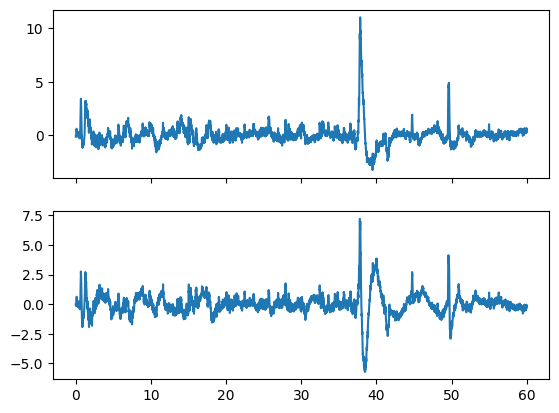

(2, 14, 7680)


In [55]:
# Filter Params
LOWCUT = 0.1
HIGHCUT = 45.0
ORDER = 9

# Bool for plotting first filter
plotData = True
# Initialize empty matrix to put all filtered data into
filterData = np.zeros_like(raw)

# Iterate through each epoch/recording
for idx in range(raw.shape[0]):
    # Get the epoch of the index
    epoch = raw[idx]
    # Initialize empty matrix to put filtered epoch data into
    filteredEpoch = np.zeros_like(epoch)

    # Iterate through the rows of the epoch/recording
    # Each row is a 1D vector of one electrodes values
    for i in range(epoch.shape[0]):
        # Get the row of the index
        channel = epoch[i]
        # Use the butterworth bandpass filter from 0.1-45 Hz
        filtered = butter_bandpass_filter(channel, LOWCUT, HIGHCUT, HZ, order=ORDER)

        # Test plotting the filtered data
        if (plotData):
            t = np.linspace(0, 60, 128*60, False) # timesteps for 60@128Hz
            fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
            ax1.plot(t, channel)
            ax2.plot(t, filtered)
            plt.show()
            plotData = False
        
        # Add filtered channel into the filterEpoch matrix
        filteredEpoch[i] = filtered
    
    # Add filtered epoch into the filterData matrix
    filterData[idx] = filteredEpoch

print(filterData.shape)

## Butterworth Band-Pass Filter

- $\alpha$ (1-7 Hz), $\beta$ (8-13 Hz), $\theta$ (14-30 Hz), $\lambda$ (30-45 Hz)
- This will break up the single stream of data from each channel into 4 streams of separate bands

Input Matrix Shape: `1280 x 4 x 32 x 7680`

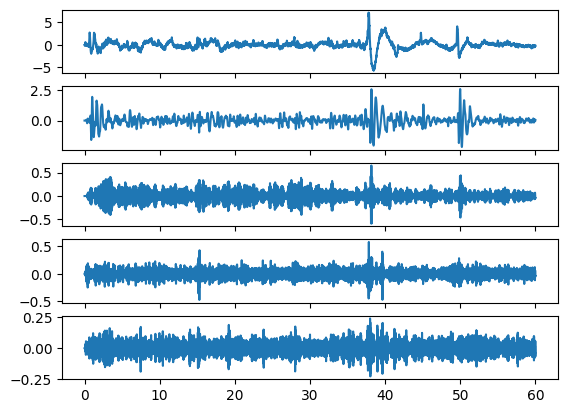

(2, 4, 14, 7680)


In [57]:
# Filter Params
ALPHA = (1, 7)
BETA = (8, 13)
THETA = (14, 30)
LAMBDA = (30, 45)
ORDER = 9

# Bool for plotting first filter
plotData = True
# Initialize empty list to put all epoched band data into
bandData = []

# Iterate through each filtered epoch/recording
for idx in range(filterData.shape[0]):
    # Get the epoch of the index
    epoch = filterData[idx]
    # Initialize empty matrixs to put band data into
    alphaData = np.zeros_like(epoch)
    betaData = np.zeros_like(epoch)
    thetaData = np.zeros_like(epoch)
    lambdaData = np.zeros_like(epoch)

    # Iterate through the rows of the filtered epoch/recording
    # Each row is a 1D vector of one electrodes values
    for i in range(epoch.shape[0]):
        # Get the row of the index
        channel = epoch[i]
        # Use the butterworth bandpass filter for each band on a channel
        alphaChan = butter_bandpass_filter(channel, ALPHA[0], ALPHA[1], HZ, order=ORDER)
        betaChan = butter_bandpass_filter(channel, BETA[0], BETA[1], HZ, order=ORDER)
        thetaChan = butter_bandpass_filter(channel, THETA[0], THETA[1], HZ, order=ORDER)
        lambdaChan = butter_bandpass_filter(channel, LAMBDA[0], LAMBDA[1], HZ, order=ORDER)

        # Test plotting the filtered data
        if (plotData):
            t = np.linspace(0, 60, 128*60, False) # timesteps for 60@128Hz
            fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, sharex=True)
            ax1.plot(t, channel)
            ax2.plot(t, alphaChan)
            ax3.plot(t, betaChan)
            ax4.plot(t, thetaChan)
            ax5.plot(t, lambdaChan)
            plt.show()
            plotData = False

        # Add each band channel vector into its respective matrix
        alphaData[i] = alphaChan
        betaData[i] = betaChan
        thetaData[i] = thetaChan
        lambdaData[i] = lambdaChan
    
    # Initialize list of band data
    epochBandData = [alphaData, betaData, thetaData, lambdaData]
    # Take the list of 2D numpy arrays and
    # convert it to 3D matrix
    epochBandData = np.stack(epochBandData)
    # Append the epochBandData to bandData list
    bandData.append(epochBandData)

# Take the list of 3D numpy arrays and 
# convert it to 4D matrix
bandData = np.stack(bandData)

print(bandData.shape)
#print(filterData.shape)

## Testing Butterworth Function from SciPy

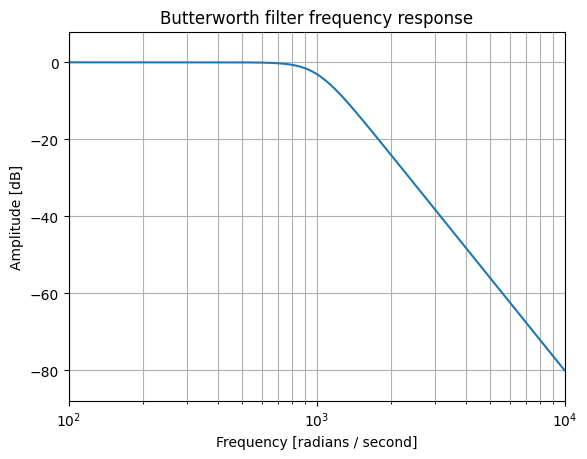

In [2]:
# Design an analog filter and plot its frequency response, showing the crticial points
b, a = butter(4, 1000, 'low', analog=True)
w, h = freqs(b, a)
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(100, color='green') # cutoff frequency
plt.show()

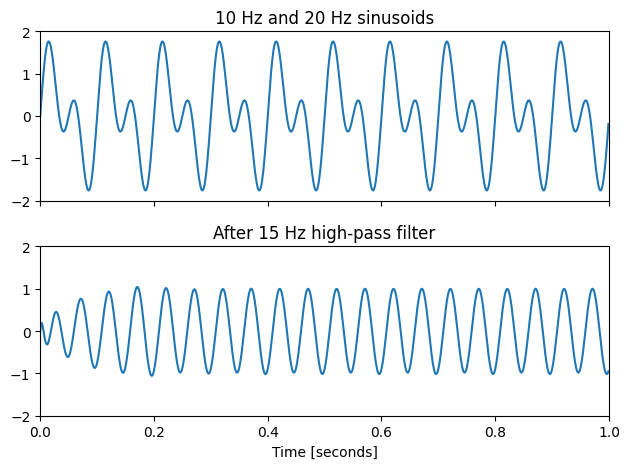

In [35]:
# Generate a signal made up of 10 Hz and 20 Hz, sampled at 1 kHz
t = np.linspace(0, 1, 1000, False) # 1 second
sig = np.sin(2*np.pi*10*t) + np.sin(2*np.pi*20*t)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(t, sig)
ax1.set_title('10 Hz and 20 Hz sinusoids')
ax1.axis([0, 1, -2, 2])
# Design a digital high-pass filter at 15Hz to remove the 10 Hz tone, and apply it to the signal.
# (It's recommended to use second-order sections format when filtering, to avoid numerical error with
# transfer function (ba) format):
sos = butter(10, 15, 'hp', fs=1000, output='sos')
filtered = sosfilt(sos, sig)
ax2.plot(t, filtered)
ax2.set_title('After 15 Hz high-pass filter')
ax2.axis([0, 1, -2, 2])
ax2.set_xlabel('Time [seconds]')
plt.tight_layout()
plt.show()

## Epoch the Epochs

- For each trils of 60 s, 14 segments are obtained using an 8 s time window moving every 4 s.
- This will extrapolate our training data
- (128 * 60) => (128 * 8)
- 7680 => 1024
- 1280 * 14 = 17920
- Increasing our input data means we increase output
- All 14 new samples from each apoch have the same output

Input Matrix Shape: `17920 x 4 x 32 x 1024`

Output Matrix Shape: `17920 x 2`

In [72]:
# Initialize empty list to put all 8 seconds epochs into
epochData = []

# Iterate through each filtered band epoch/recording
for idx in range(bandData.shape[0]):
    # Get the epoch of the index
    epoch = bandData[idx]

    # Iterrate through 8 second time intervals 
    for t in range(0, epoch.shape[2], HZ*4):
        # Break if 8 seconds goes past end of recording
        if (t + HZ*8 > epoch.shape[2]):
            break

        # Initialize empty matrix to put 8 s epoch into (4, 14, 1024)
        epoch8 = np.zeros((epoch.shape[0], epoch.shape[1], HZ*8))

        # Iterate through each band in the epoch
        for i in range(epoch.shape[0]):
            # Add the time interval from this
            # band into the epoch8 matrix
            epoch8[i] = epoch[i,:,t:t+HZ*8]

        # Append 8 second epoch to epochData list
        epochData.append(epoch8)

# Take the list of 3D numpy arrays and 
# convert it to 4D matrix
epochData = np.stack(epochData)

print(epochData.shape)

(28, 4, 14, 1024)


## PCC Feature Extraction

- PCC (Pearson Correlation Coefficient)
- On every band and epoch
- Basically calculating correlation of every channel pair against each other
- (32 x 1024) => (32 x 32)

Input Matrix Shape: `17920 x 4 x 32 x 32`

In [78]:
# Initialize empty list to put the PCC data into
pccData = []

print(epochData.shape)
# Iterate through each epoch
for idx in range(epochData.shape[0]):
    # Get the epoch of the index
    epoch = epochData[idx]
    # Initialize empty list to put the epoch PCC data into
    pccEpoch = []
    
    # Iterate through each band
    for i in range(epoch.shape[0]):
        # Get the band of the index
        band = epoch[i]
        # Extract PCC from the band
        pcc = np.corrcoef(band)
        # Append PCC features into pccEpoch list
        pccEpoch.append(pcc)

    # Take the list of 2D numpy arrays and
    # convert it to 3D matrix
    pccEpoch = np.stack(pccEpoch)
    # Append the pccEpoch to pccData list
    pccData.append(pccEpoch)
    
# Take the list of 3D numpy arrays and
# convert it to 4D matrix
pccData = np.stack(pccData)

print(pccData.shape)


(28, 4, 14, 1024)
(28, 4, 14, 14)


## Split Training and Testing Set

- 80% Training, 20% Testing

Training Input Matrix Shape: `14336 x 4 x 32 x 32`

Training Output Matrix Shape: `14336 x 2`

Testing Input Matrix Shape: `3584 x 4 x 32 x 32`

Testing Output Matrix Shape: `3584 x 2`

In [ ]:
# Will be implemented once we know what the output data is.

## Develop Convolutional Neural Network (CNN)

- Input Convolutional Layer
    - Input Size: Four 32 x 32 "images" (4 bands PCC matrix)
    - Kernel Size = 3 x 1
    - \# of Kernels = 32
- Hidden Convolutional Layer
    - Kernel Size = 3 x 1
    - \# of Kernels = 32
- Dropout Layer
- Hidden Max-Pooling Layer
    - Pooling Size = 3 x 3
    - \# of Kernels = 64
- Dropout Layer
- Staging Layer
    - Shape: 64 x 10 x 9
- Output Layer
    - (Valence, Arousal) tuple

In [ ]:
# Will be implemented once we know what the output data is.

## Train CNN

- Training Epochs = 50
- Batch Size = 128
- Learning Rate = 0.01

In [ ]:
# Will be implemented once we know what the output data is.

## After Training, Drop Output Layer

- This makes the Staging Layer the new Output Layer
- Run Training Input Matrix through CNN an get the output.
- **Note:** Just using a CNN for classification is known to not have the best results. This is the main idea of the paper. We initially have a 2-neuron output layer for training in order for back propagation in the CNN to adjust the weights, but then dorp the output layer and take the data in the staging layer, flatten it, and put it into the SAE

Training Input Matrix Size: `14336 x 64 x 10 x 9`

In [ ]:
# Will be implemented once we know what the output data is.

## Flatten 3D Output From CNN into 1D Vector

- Data needs to be one-dimensional to go into SAE

Training Input Matrix Size: `14336 x 5760`

In [ ]:
# Will be implemented once we know what the output data is.

## Develop Sparse Autoencoder (SAE)

- Input Layer: 5760 Nodes
- Encoder Layer: 512 Nodes
- Hidden Layer: 128 Nodes
- Output Decoder Layer: 512 Nodes

In [ ]:
# Will be implemented once we know what the output data is.

## Train SAE

- SAE's are unsupervised learning models so we don't train it against an expected output.
- Training Epochs = 100
- Batch Size = 64
- Learning Rate = 0.01

In [ ]:
# Will be implemented once we know what the output data is.

## Get SAE Output

- Using the flattened output from the CNN as input to the trained SAE, get the output to use as training data for DNN

Training Input Matrix Shape: `14336 x 512`

In [ ]:
# Will be implemented once we know what the output data is.

## Develop Deep Neural Network (DNN)

- Fully Connected Input Layer: 512 Nodes
- Fully Connected Hidden Layer: 256 Nodes
- Fully Connected Output Layer: 2 Nodes ((Valence, Arousal) tuple)

In [ ]:
# Will be implemented once we know what the output data is.

## Train DNN

- Use the output of the trained SAE as training input for the DNN. The expected outputs to the DNN are teh original (V,A) tuple.
- Training Epochs = 100
- Batch Size = 128
- Learning Rate = 0.01

In [ ]:
# Will be implemented once we know what the output data is.

## Analyze Full Model with Testing Set

- `3584 x 4 x 32 x 32` ==CNN==> ==SAE==> ==DNN==> `3584 x 2`

In [ ]:
# Will be implemented once we know what the output data is.